In [68]:
from imports.ExtractContactCases import ExtractContactCases

ex = ExtractContactCases('contact_extraction1')
samples = ex.load()

In [69]:
import pandas as pd
import numpy as np

centroids_ = pd.read_csv('centroids.csv')
cents = centroids_.values[:, :2][:, ::-1]
cents[:5]

array([[153.55172414,  50.03448276],
       [180.4494382 ,  54.47191011],
       [126.75      ,  55.94736842],
       [153.56666667,  69.6       ],
       [202.41111111,  69.58888889]])

In [70]:
from sklearn.model_selection import train_test_split
from torch_geometric import seed_everything
seed_everything(0)

sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-0.6, random_state=0) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx,  test_size=0.5, random_state=0) #fixed across extractions

In [71]:
from scipy.spatial.distance import cdist
from imports.TactileDataset import cases_dict, list_of_rotations

X_val = np.zeros((len(val_idx), 53))
y_val = np.zeros((len(val_idx), 2))

for i, sample_idx in enumerate(val_idx):
    pos = np.array(samples[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_val[i, node_idx] = sum(events_idx)
    y_val[i] = cases_dict[samples[sample_idx]['case']]

In [72]:
from scipy.spatial.distance import cdist
from imports.TactileDataset import cases_dict, list_of_rotations

X_train = np.zeros((len(train_idx), 53))
y_train = np.zeros((len(train_idx), 2))

for i, sample_idx in enumerate(train_idx):
    pos = np.array(samples[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_train[i, node_idx] = sum(events_idx)
    y_train[i] = cases_dict[samples[sample_idx]['case']]

In [73]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=300, max_depth=2)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [74]:
np.degrees(np.mean(np.abs(reg.predict(X_val) - y_val)))

0.8501690720641125

In [75]:
np.degrees(np.max(np.abs(reg.predict(X_val) - y_val)))

3.8335008745039567

In [76]:
def rotate_case(ev_arr, label, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))
    
    ev_arr = np.array(ev_arr)
    centered = ev_arr[:, :2] - np.array((158, 121))
    rot_ev = (R @ centered.T)
    rot_ev = rot_ev.T + np.array((158, 121))
    
    rot_v = np.array(cases_dict[label])
    new_rot_v = R @ rot_v
    #print(new_rot_v, cases_dict[label])

    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    
    for rot in list_of_rotations:
        diff_vals = np.sqrt( np.power(rot[0] - new_rot_v[0], 2) +  np.power(rot[1] - new_rot_v[1], 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    
    return best_rot_idx, np.concatenate([rot_ev.astype(int), ev_arr[:, 2:]], -1)


In [77]:
def aug_gen():
    for i, sample_idx in enumerate(train_idx):
        for angle in [0, 90]:
            if angle == 0:
                yield samples[sample_idx]
            else:
                case, events = rotate_case(samples[sample_idx]['events'], samples[sample_idx]['case'], angle)
                yield {'events': events, 'case': case}

In [78]:
samples_train = {f'sample_{i+1}': sam for i, sam in enumerate(aug_gen())}

In [79]:
X_train_aug = np.zeros((len(samples_train), 53))
y_train_aug = np.zeros((len(samples_train), 2))

for i, sample_idx in enumerate(list(samples_train.keys())):
    pos = np.array(samples_train[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_train_aug[i, node_idx] = sum(events_idx)
    y_train_aug[i] = cases_dict[samples_train[sample_idx]['case']]

In [80]:
X_train_aug.shape

(772, 53)

In [134]:
reg_aug = xgb.XGBRegressor(n_estimators=1000, max_depth=3, eta=0.001)
reg_aug.fit(X_train_aug, y_train_aug)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.001,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.00100000005,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [135]:
np.degrees(np.mean(np.abs(reg_aug.predict(X_val) - y_val)))

10.537474051267107

In [136]:
np.degrees(np.mean(np.abs(reg_aug.predict(X_train_aug) - y_train_aug)))

10.56567400055451

In [116]:
np.degrees(np.max(np.abs(reg_aug.predict(X_val) - y_val)))

5.8923332936887975

In [86]:
np.degrees(np.mean(np.abs(reg.predict(X_train) - y_train)))

0.08200791166609613

## ROTATION

In [17]:
sample = samples['sample_101']

In [18]:
angle = 180
ev_arr = np.array(sample['events'])
label = sample['case']

theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

ev_arr = np.array(ev_arr)
centered = ev_arr[:, :2] - np.array((158, 121))
rot_ev = (R @ centered.T[:, ::-1])
rot_ev = rot_ev.T[:, ::-1] + np.array((158, 121))

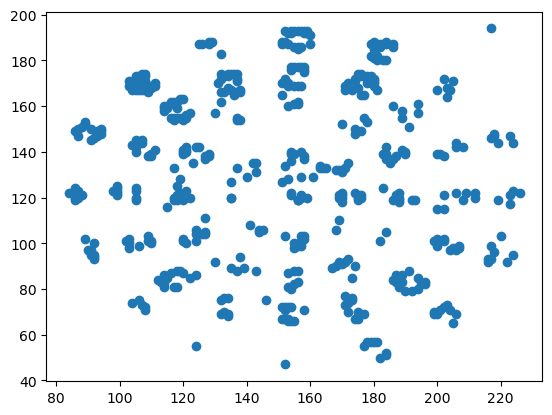

In [19]:
import matplotlib.pyplot as plt
plt.scatter(*ev_arr[:, :2].T)

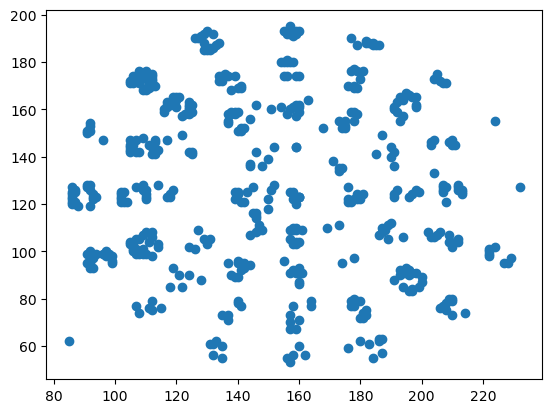

In [20]:
import matplotlib.pyplot as plt
plt.scatter(*rot_ev[:, :2].T)

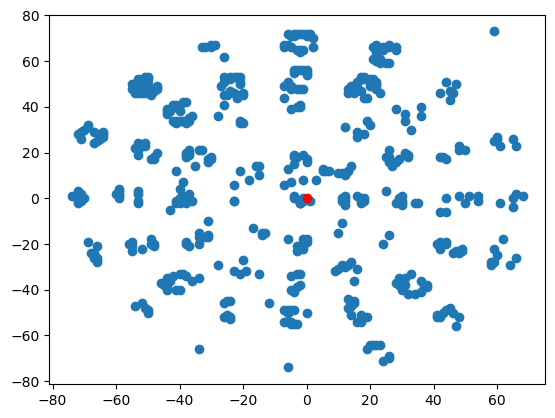

In [21]:
plt.scatter(*centered.T)
plt.scatter(0, 0, c='r')

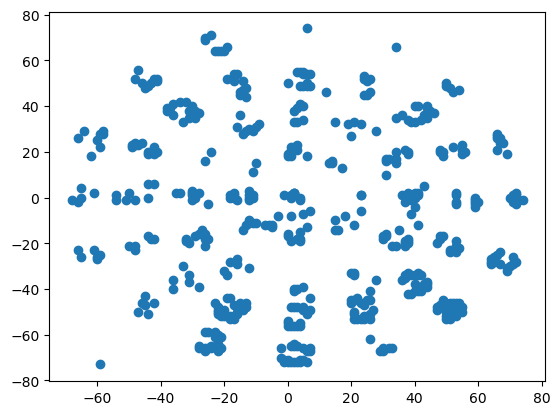

In [22]:
plt.scatter(*(R @ centered.T))

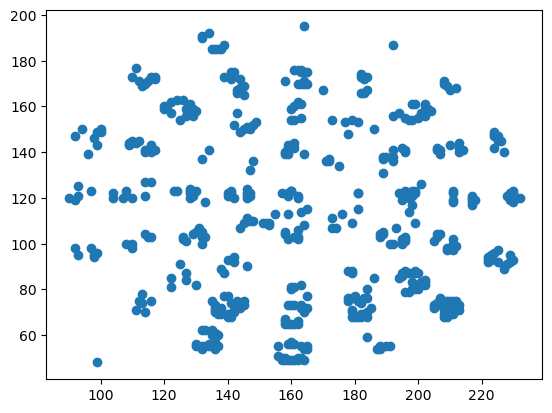

In [23]:
plt.scatter(*((R @ centered.T).T + np.array((158, 121))).T)

In [31]:
ev_arr[:, 0].max()

226

In [26]:
imgs = np.zeros((260, 346))
imgs

for x, y in ev_arr[:, :2]:
    imgs[x, y] = 1

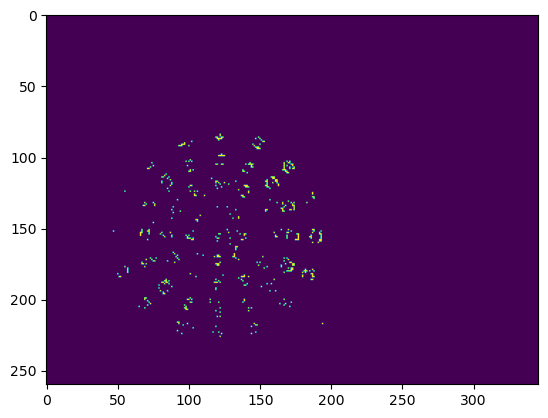

In [27]:
plt.imshow(imgs)

In [197]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [203]:
np.mean(np.abs(lr.predict(X_train) - y_train)) * 180/np.pi

0.9284059867985583

In [204]:
np.mean(np.abs(lr.predict(X_val) - y_val)) * 180/np.pi

1.038390878855492

## ANN


In [192]:
import torch

class ann(torch.nn.Module):
    def __init__(self):
        super(ann, self).__init__()
        self.layer1 = torch.nn.Linear(53, 2)
    def forward(self, x):
        out = self.layer1(x)
        return torch.nn.functional.relu(out)
    
model = ann().cuda()

In [209]:
from torch import nn

loss_func = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [210]:
from tqdm.auto import tqdm, trange


for epoch in trange(500):
 
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = model(X_train_tensor.cuda())
 
    # Compute and print loss
    loss = loss_func(pred_y, y_train_tensor.cuda())
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  0%|          | 0/500 [00:00<?, ?it/s]

In [211]:
X_val_tensor = torch.from_numpy(X_val.astype(np.float32)).cuda()
y_val_tensor = torch.from_numpy(y_val.astype(np.float32)).cuda()

In [212]:
model(X_train_tensor.cuda())

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0